## 1) Basic Residual Block: Genel Tanım

Basic residual block, giriş x’i iki yola ayırır:

* Main path: x’ten bir dönüşüm üretir → F(x)
(genelde: Conv → BN → ReLU → Conv → BN)

* Skip path: x’i mümkünse aynı bırakır → identity

Sonra bunları toplar:

**y=F(x)+x**

* Eğer boyutlar aynı değilse (stride=2 veya kanal değişimi), skip path’e projection koyar:


**y=F(x)+W_s x**

> Burada W_s pratikte 1×1 Conv + BN’dir.

-----
------

## 2) Kod Çalışması — Seviye 0: “Residual fikrini çıplak” gösterelim

**İlk amaç: “Toplama” mantığını kodda görmek (Conv falan yok).**

In [1]:
import torch 
import torch.nn as nn

class ToyResidual(nn.Module):
    def __init__(self, channels:int):
        super().__init__()
        self.f = nn.Conv2d(channels,channels,kernel_size=1,bias=False)
    
    def forward(self,x):
        return self.f(x) + x

x = torch.randn(2, 32, 56, 56)
m = ToyResidual(32)
y = m(x)
print(x.shape, y.shape)

torch.Size([2, 32, 56, 56]) torch.Size([2, 32, 56, 56])


* Bu aşamada öğrenilecek tek şey:

**F(x) ne olursa olsun, y = F(x) + x.**

-----
------

## 3) Seviye 1: Gerçek Basic Residual Block (identity shortcut)
Şimdi “gerçek” basic block’un standart hali:

* Conv3×3 → BN → ReLU

* Conv3×3 → BN

- Add

* ReLU

In [ ]:
import torch
import torch.nn as nn

class BasicResidualBlock(nn.Module):
    def __init__(self, channels:int):
        super().__init__()

        self.conv1 = nn.Conv2d(channels,channels,3,stride=1,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        self.conv2 = nn.Conv2d(channels,channels,3,stride = 1,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        self.relu = nn.ReLU(inplace=False)

    def forward(self,x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out = out + identity
        out = self.relu(out)
        return out 

x = torch.randn(2, 64, 56, 56)
block = BasicResidualBlock(64)
y = block(x)
print(x.shape, y.shape)

torch.Size([2, 64, 56, 56]) torch.Size([2, 64, 56, 56])


-----
------

## 4) Seviye 2: Projection shortcut (stride=2 / kanal değişimi)

Burada ilk defa “asıl kritik konu” geliyor: toplama için boyut eşitliği.

In [ ]:
import torch
import torch.nn as nn

class BasicResidualBlockProj(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, stride: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.relu = nn.ReLU(inplace=False)

        self.downsampling = None
        if stride !=1 or in_ch!=out_ch:
            self.downsampling = nn.Sequential(
                nn.Conv2d(in_ch,out_ch,kernel_size=1,stride=stride,bias =False),
                nn.BatchNorm2d(out_ch),
        )
            
    def forward(self,x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.downsampling is not None:
            identity = self.downsampling(identity)
        
        out = out + identity
        out = self.relu(out)
        return out 

x = torch.randn(2, 64, 56, 56)
block = BasicResidualBlockProj(64, 128, stride=2)
y = block(x)
print(x.shape, y.shape)  # (2,64,56,56) -> (2,128,28,28)

torch.Size([2, 64, 56, 56]) torch.Size([2, 128, 28, 28])


-----
------

## 5) Shape Debug Alışkanlığı (forward içinde kontrol)
### 5.1 En kritik kural

Residual’da toplama yapacaksak:

**out.shape == identity.shape** olmak zorunda.

* Bu yoksa residual değil, patlar.

### 5.2 Debug için pratik şablon (assert + net hata)

In [ ]:
import torch
import torch.nn as nn

def _tensor_bilgi(t: torch.Tensor) -> str:
    return f"şekil={tuple(t.shape)}, dtype={t.dtype}, cihaz={t.device}"

class BasicResidualBlockDebugTR(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, stride: int = 1, debug: bool = False):
        super().__init__()
        self.debug = debug

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.relu  = nn.ReLU(inplace=False)

        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.debug and x.ndim != 4:
            raise RuntimeError(
                "HATA: Girdi 4 boyutlu (N, C, H, W) olmalı.\n"
                f"  Gelen tensor: {_tensor_bilgi(x)}"
            )

        output = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            output = self.downsample(output)

        if self.debug and out.shape != output.shape:
            raise RuntimeError(
                "HATA: Residual toplama için boyutlar uyuşmuyor!\n"
                f"  Ana yol (out):   {_tensor_bilgi(out)}\n"
                f"  Kısayol (skip):  {_tensor_bilgi(output)}\n\n"
                "Muhtemel sebep:\n"
                "- stride=2 yaptın ama outputu (skip path) aynı bıraktın.\n"
                "- veya in_ch/out_ch değişti ama projection (1x1 conv) eksik.\n\n"
                "Çözüm:\n"
                "- stride veya kanal değişiyorsa outputa 1x1 conv + BN ekle (projection).\n"
                "- Bu sınıfta downsample otomatik eklenir; parametreleri kontrol et."
            )

        out = self.relu(out + output)
        return out

### 1--) Test A — Doğru senaryolar (hata vermemeli)

In [11]:
x = torch.randn(2, 64, 56, 56)

print("Test A1: Identity (stride=1, kanal aynı)")
b1 = BasicResidualBlockDebugTR(64, 64, stride=1, debug=True)
y1 = b1(x)
print("  OK çıktı:", y1.shape)

print("\nTest A2: Projection (stride=2, kanal değişiyor)")
b2 = BasicResidualBlockDebugTR(64, 128, stride=2, debug=True)
y2 = b2(x)
print("  OK çıktı:", y2.shape)


Test A1: Identity (stride=1, kanal aynı)
  OK çıktı: torch.Size([2, 64, 56, 56])

Test A2: Projection (stride=2, kanal değişiyor)
  OK çıktı: torch.Size([2, 128, 28, 28])


### 2--) Test B — Bilerek hata üretelim (projection yokmuş gibi davranacağız)

Bunun için “hatalı” bir blok yazıyoruz: stride=2 yapıyor ama skip path’i hiç downsample etmiyor. Debug modunda patlaması lazım.

**Beklenen: Türkçe RuntimeError mesajı + shape’ler.**

In [14]:
class HATALI_ResidualBlock(nn.Module):
    def __init__(self, ch: int, stride: int = 2, debug: bool = True):
        super().__init__()
        self.debug = debug
        # Ana yol stride=2 ile küçülüyor
        self.conv1 = nn.Conv2d(ch, ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(ch)
        self.conv2 = nn.Conv2d(ch, ch, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(ch)
        self.relu  = nn.ReLU(inplace=False)

    def forward(self, x):
        kisayol = x  # HATA: stride=2 olmasına rağmen kısayol aynı kalıyor

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.debug and out.shape != kisayol.shape:
            raise RuntimeError(
                "HATA (Bilerek): Ana yol ile kısayol boyutu farklı!\n"
                f"  Ana yol (out):  {_tensor_bilgi(out)}\n"
                f"  Kısayol (skip): {_tensor_bilgi(kisayol)}\n"
                "Çözüm: Skip path'e projection (1x1 conv + stride) eklemelisin."
            )

        return self.relu(out + kisayol)

In [15]:
x = torch.randn(2, 64, 56, 56)

print("Test B: Bilerek bozduk (stride=2 ama projection yok)")
bad = HATALI_ResidualBlock(64, stride=2, debug=True)
y = bad(x)  # burada RuntimeError bekleniyor


Test B: Bilerek bozduk (stride=2 ama projection yok)


RuntimeError: HATA (Bilerek): Ana yol ile kısayol boyutu farklı!
  Ana yol (out):  şekil=(2, 64, 28, 28), dtype=torch.float32, cihaz=cpu
  Kısayol (skip): şekil=(2, 64, 56, 56), dtype=torch.float32, cihaz=cpu
Çözüm: Skip path'e projection (1x1 conv + stride) eklemelisin.

-----
------

# 6) Forward görselleştirme: Shape + Projection aktif mi?

Bu, residual’ın “shortcut identity mi projection mı” kararını kod üstünde gösterir.

Burada ekranda şunu görmemiz lazım:

* stride=1, kanal aynı → identity

* stride=2 veya kanal değişimi → projection 1x1

In [16]:
import torch
import torch.nn as nn

class BasicResidualBlockVis(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=False)

        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x, verbose=False):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        used_proj = self.downsample is not None
        if used_proj:
            identity = self.downsample(identity)

        if verbose:
            print("---- BasicResidualBlock ----")
            print(f"Input x:      {tuple(x.shape)}")
            print(f"Main out:     {tuple(out.shape)}  (F(x))")
            print(f"Shortcut:     {tuple(identity.shape)}  ({'projection 1x1' if used_proj else 'identity'})")
            print(f"Add result:   {tuple((out+identity).shape)}  (F(x)+shortcut)")
            print("---------------------------")

        out = self.relu(out + identity)
        return out

# Test: identity shortcut
x = torch.randn(2, 64, 56, 56)
b1 = BasicResidualBlockVis(64, 64, stride=1)
_ = b1(x, verbose=True)

# Test: projection shortcut
b2 = BasicResidualBlockVis(64, 128, stride=2)
_ = b2(x, verbose=True)


---- BasicResidualBlock ----
Input x:      (2, 64, 56, 56)
Main out:     (2, 64, 56, 56)  (F(x))
Shortcut:     (2, 64, 56, 56)  (identity)
Add result:   (2, 64, 56, 56)  (F(x)+shortcut)
---------------------------
---- BasicResidualBlock ----
Input x:      (2, 64, 56, 56)
Main out:     (2, 128, 28, 28)  (F(x))
Shortcut:     (2, 128, 28, 28)  (projection 1x1)
Add result:   (2, 128, 28, 28)  (F(x)+shortcut)
---------------------------


-----
-----
# 7) Backward görselleştirme: “Gradient akıyor mu?” (plot)

Bu daha “vay be” dedirten kısım. Aynı derinlikte:

* Plain blok (skip yok)

* Residual blok (skip var)

Sonra her adımda:

* loss

**stem (en erken katman) grad norm toplayıp grafiğini çiziyoruz.**

In [20]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def pick_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

class PlainBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(8, ch)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(8, ch)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.relu(self.gn1(self.conv1(x)))
        x = self.relu(self.gn2(self.conv2(x)))
        return x

class ResidualBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(8, ch)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(8, ch)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        identity = x
        out = self.relu(self.gn1(self.conv1(x)))
        out = self.gn2(self.conv2(out))
        return self.relu(out + identity)

class ToyNet(nn.Module):
    def __init__(self, block_cls, depth=30, ch=64, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, ch, 3, padding=1, bias=False),
            nn.GroupNorm(8, ch),
            nn.ReLU(inplace=False),
        )
        self.blocks = nn.Sequential(*[block_cls(ch) for _ in range(depth)])
        self.head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(ch, num_classes))

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        return self.head(x)

def grad_norm(module):
    s = 0.0
    for p in module.parameters():
        if p.grad is None:
            continue
        s += p.grad.detach().pow(2).sum().item()
    return s ** 0.5

device = pick_device()
torch.manual_seed(0)

depth = 30
steps = 120
batch = 32
lr = 5e-3

plain = ToyNet(PlainBlock, depth=depth).to(device)
res = ToyNet(ResidualBlock, depth=depth).to(device)

opt_p = torch.optim.SGD(plain.parameters(), lr=lr, momentum=0.9)
opt_r = torch.optim.SGD(res.parameters(), lr=lr, momentum=0.9)

x_fixed = torch.randn(batch, 3, 32, 32, device=device)
y_fixed = torch.randint(0, 10, (batch,), device=device)

lp, lr_, gp, gr = [], [], [], []

t0 = time.time()
for step in range(steps):
    opt_p.zero_grad(set_to_none=True)
    loss_p = F.cross_entropy(plain(x_fixed), y_fixed)
    loss_p.backward()
    gp.append(grad_norm(plain.stem))
    opt_p.step()
    lp.append(loss_p.item())

    opt_r.zero_grad(set_to_none=True)
    loss_r = F.cross_entropy(res(x_fixed), y_fixed)
    loss_r.backward()
    gr.append(grad_norm(res.stem))
    opt_r.step()
    lr_.append(loss_r.item())

    if (step + 1) % 20 == 0:
        print(f"[{step+1:03d}/{steps}] plain_loss={loss_p.item():.4f} plain_grad={gp[-1]:.3e} | res_loss={loss_r.item():.4f} res_grad={gr[-1]:.3e}")

print(f"Bitti. cihaz={device}, süre={time.time()-t0:.2f}s")

plt.figure()
plt.plot(lp, label="Skip YOK (düz CNN) - loss")
plt.plot(lr_, label="Skip VAR (Residual) - loss")
plt.legend()
plt.title("Skip bağlantısı gradient’i nasıl etkiliyor?")
plt.savefig("loss.png", dpi=200, bbox_inches="tight")
plt.close()

plt.figure()
plt.plot(gp, label="Skip YOK (düz CNN) - giriş katmanı gradient gücü")
plt.plot(gr, label="Skip VAR (Residual) - giriş katmanı gradient gücü")
plt.legend()
plt.title("Skip bağlantısı gradient’i nasıl etkiliyor?")    
plt.savefig("grad.png", dpi=200, bbox_inches="tight")
plt.close()

print("Çıktılar: loss.png ve grad.png")

[020/120] plain_loss=2.1786 plain_grad=1.004e-03 | res_loss=5.7326 res_grad=5.945e-01
[040/120] plain_loss=2.1738 plain_grad=6.235e-03 | res_loss=2.5151 res_grad=1.395e-01
[060/120] plain_loss=2.1665 plain_grad=2.109e-02 | res_loss=2.1663 res_grad=7.357e-02
[080/120] plain_loss=2.1724 plain_grad=9.385e-02 | res_loss=2.0690 res_grad=9.323e-02
[100/120] plain_loss=2.0387 plain_grad=1.656e-01 | res_loss=1.9716 res_grad=1.200e-01
[120/120] plain_loss=2.1778 plain_grad=4.824e-02 | res_loss=1.7958 res_grad=2.139e-01
Bitti. cihaz=cpu, süre=561.51s
Çıktılar: loss_fixed.png ve grad_fixed.png


----
----
# 8-) Şimdi geldik en önemli kısıma.Bundan önce yazdığımız CA+CBAM Attention a bu kodu oturtalım.Bakalım birleşimi ve işleyişi nasıl olacak.

### CA+CBAM ATTENTİON

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def softplus_inverse(y: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    return torch.log(torch.clamp(torch.exp(y) - 1.0, min=eps))

def _get_gate(gate: str):
    g = gate.lower()
    if g == "sigmoid":
        return torch.sigmoid
    if g == "hardsigmoid":
        return F.hardsigmoid
    raise ValueError("gate 'sigmoid' veya 'hardsigmoid' olmalı.")

def _get_act(act: str):
    a = act.lower()
    if a == "relu":
        return nn.ReLU(inplace=True)
    if a == "silu":
        return nn.SiLU(inplace=True)
    raise ValueError("act 'relu' veya 'silu' olmalı.")

class ChannelAttentionFusionT(nn.Module):
    def __init__(
        self,
        channels: int,
        reduction: int = 16,
        min_hidden: int = 4,
        fusion: str = "softmax",
        gate: str = "sigmoid",
        temperature: float = 0.9,
        learnable_temperature: bool = False,
        eps: float = 1e-6,
        act: str = "relu",
        bias: bool = True,
        fusion_router_hidden: int = 16,
        return_fusion_weights: bool = False,
        t_min: float = 0.5,
        t_max: float = 3.0,
        router_temperature: float = 1.5,
        beta_ca: float = 0.35,
    ):
        super().__init__()

        if channels < 1:
            raise ValueError("channels >= 1 olmalı.")
        if reduction < 1:
            raise ValueError("reduction >= 1 olmalı.")
        if fusion not in ("sum", "softmax"):
            raise ValueError("fusion 'sum' veya 'softmax' olmalı.")
        if temperature <= 0:
            raise ValueError("temperature pozitif olmalı.")
        if fusion == "softmax" and fusion_router_hidden < 1:
            raise ValueError("fusion_router_hidden >= 1 olmalı.")
        if t_min <= 0 or t_max <= 0 or t_min > t_max:
            raise ValueError("T clamp aralığı hatalı.")
        if router_temperature <= 0:
            raise ValueError("router_temperature pozitif olmalı.")
        if beta_ca < 0:
            raise ValueError("beta_ca >= 0 olmalı.")

        self.eps = float(eps)
        self.fusion = fusion
        self.return_fusion_weights = bool(return_fusion_weights)
        self.gate_fn = _get_gate(gate)

        self.t_min = float(t_min)
        self.t_max = float(t_max)
        self.Tr = float(router_temperature)
        self.beta_ca = float(beta_ca)

        hidden = max(int(min_hidden), int(channels) // int(reduction))
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, hidden, kernel_size=1, bias=bias)
        self.act = _get_act(act) # silu , relu
        self.fc2 = nn.Conv2d(hidden, channels, kernel_size=1, bias=bias)

        if self.fusion == "softmax":
            self.fusion_router = nn.Sequential(
                nn.Conv2d(2 * channels, fusion_router_hidden, kernel_size=1, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(fusion_router_hidden, 2, kernel_size=1, bias=True),
            )
            last = self.fusion_router[-1] # [-1] = “en sondaki eleman" 
            nn.init.zeros_(last.weight)
            nn.init.zeros_(last.bias)
        else:
            self.fusion_router = None

        self.learnable_temperature = bool(learnable_temperature)
        if self.learnable_temperature:
            t0 = float(temperature)
            lo = self.t_min + self.eps
            hi = self.t_max - self.eps
            if lo >= hi:
                lo = self.t_min
                hi = self.t_max
            t0 = min(max(t0, lo), hi)
            t_inv = softplus_inverse(torch.tensor(t0), eps=self.eps)
            self.t_raw = nn.Parameter(t_inv)
        else:
            self.register_buffer("T", torch.tensor(float(temperature)))

    def get_T(self, x: torch.Tensor) -> torch.Tensor:
        if self.learnable_temperature:
            T = F.softplus(self.t_raw) + self.eps
        else:
            T = self.T
        T = T.to(device=x.device, dtype=x.dtype)
        return T.clamp(self.t_min, self.t_max)

    def mlp(self, s: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.act(self.fc1(s)))

    def forward(self, x: torch.Tensor):
        avg_s = self.avg_pool(x)
        max_s = self.max_pool(x)

        a = self.mlp(avg_s)
        m = self.mlp(max_s)

        fusion_w = None
        if self.fusion == "sum":
            z = a + m
        else:
            s_cat = torch.cat([avg_s, max_s], dim=1)
            logits = self.fusion_router(s_cat).flatten(1)
            fusion_w = torch.softmax(logits / self.Tr, dim=1)
            # Softmax: “bu sample’da avg mi daha önemli max mı?” sorusuna öğrenilen ağırlık
            # Tr :: :: Softmax’ın “keskinliğini” ayarlar
            w0 = fusion_w[:, 0].view(-1, 1, 1, 1)
            w1 = fusion_w[:, 1].view(-1, 1, 1, 1)
            z = w0 * a + w1 * m

        T = self.get_T(x)
        ca = self.gate_fn(z / T)
        # T gate’in agresifliğini kontrol eden “ısı” parametresi.

        scale_ca = 1.0 + self.beta_ca * (ca - 1.0)
        y = x * scale_ca

        if self.return_fusion_weights:
            return y, ca, fusion_w
        return y, ca


class HSwish(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * F.relu6(x + 3.0, inplace=True) / 6.0

def make_norm(norm: str, ch: int):
    norm = norm.lower()
    if norm == "bn":
        return nn.BatchNorm2d(ch)
    if norm == "gn":
        g = min(32, ch)
        while ch % g != 0 and g > 2:
            g //= 2
        if ch % g != 0:
            g = 2 if (ch % 2 == 0) else 1
        return nn.GroupNorm(g, ch)
    if norm == "none":
        return nn.Identity()
    raise ValueError("norm 'none', 'bn', 'gn' dışında olamaz.")

class CoordinateAttPlus(nn.Module):
    def __init__(
        self,
        in_channels: int,
        reduction: int = 32,
        min_mid_channels: int = 8,
        act: str = "hswish",
        init_alpha: float = 0.7,
        learnable_alpha: bool = True,
        beta: float = 0.35,
        dilation: int = 2,
        norm: str = "gn",
        use_spatial_gate: bool = False,
        spatial_gate_beta: float = 0.35,
        scale_min: float = 0.6,
        scale_max: float = 1.6,
        head_init_std: float = 0.01,
    ):
        super().__init__()

        if in_channels < 1:
            raise ValueError("in_channels >= 1 olmalı.")
        if reduction < 1:
            raise ValueError("reduction >= 1 olmalı.")
        if dilation < 1:
            raise ValueError("dilation >= 1 olmalı.")
        if scale_min <= 0 or scale_max <= 0 or scale_min > scale_max:
            raise ValueError("scale clamp aralığı hatalı.")
        if head_init_std <= 0:
            raise ValueError("head_init_std pozitif olmalı.")
        if beta < 0:
            raise ValueError("beta >= 0 olmalı.")
        if spatial_gate_beta < 0:
            raise ValueError("spatial_gate_beta >= 0 olmalı.")

        self.beta = float(beta)
        self.scale_min = float(scale_min)
        self.scale_max = float(scale_max)

        mid_floor = max(8, min(32, int(in_channels) // 4))
        mid = max(int(min_mid_channels), int(in_channels) // int(reduction))
        mid = max(mid, int(mid_floor))

        act_l = act.lower()
        if act_l == "hswish":
            self.act = HSwish()
        elif act_l == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act_l == "silu":
            self.act = nn.SiLU(inplace=True)
        else:
            raise ValueError("act 'hswish', 'relu', 'silu' olmalı.")

        self.shared_bottleneck_proj = nn.Conv2d(in_channels, mid, 1, bias=False)
        self.shared_bottleneck_norm = make_norm(norm, mid)
        self.shared_bottleneck_refine = nn.Conv2d(mid, mid, 1, bias=False)
        self.shared_bottleneck_refine_norm = make_norm(norm, mid)

        self.h_local_dw = nn.Conv2d(
            in_channels, in_channels, kernel_size=(3, 1), padding=(1, 0),
            groups=in_channels, bias=False
        )
        self.w_local_dw = nn.Conv2d(
            in_channels, in_channels, kernel_size=(1, 3), padding=(0, 1),
            groups=in_channels, bias=False
        )

        d = int(dilation)
        self.h_dilated_dw = nn.Conv2d(
            in_channels, in_channels, kernel_size=(3, 1), padding=(d, 0),
            dilation=(d, 1), groups=in_channels, bias=False
        )
        self.w_dilated_dw = nn.Conv2d(
            in_channels, in_channels, kernel_size=(1, 3), padding=(0, d),
            dilation=(1, d), groups=in_channels, bias=False
        )

        self.h_channel_mixer = nn.Conv2d(in_channels, in_channels, 1, bias=True)
        self.w_channel_mixer = nn.Conv2d(in_channels, in_channels, 1, bias=True)

        self.h_attention_head = nn.Conv2d(mid, in_channels, 1, bias=True)
        self.w_attention_head = nn.Conv2d(mid, in_channels, 1, bias=True)

        nn.init.normal_(self.h_attention_head.weight, mean=0.0, std=float(head_init_std))
        nn.init.normal_(self.w_attention_head.weight, mean=0.0, std=float(head_init_std))
        if self.h_attention_head.bias is not None:
            nn.init.zeros_(self.h_attention_head.bias)
        if self.w_attention_head.bias is not None:
            nn.init.zeros_(self.w_attention_head.bias)

        eps = 1e-6
        a0 = float(init_alpha)
        a0 = min(max(a0, eps), 1.0 - eps)
        raw0 = torch.logit(torch.tensor(a0), eps=eps)
        # başlangıçta alpha=init_alpha olacak şekilde raw parametreyi ayarlamak”.

        if learnable_alpha:
            self.alpha_h_raw = nn.Parameter(raw0.clone())
            self.alpha_w_raw = nn.Parameter(raw0.clone())
        else:
            self.register_buffer("alpha_h_raw", raw0.clone())
            self.register_buffer("alpha_w_raw", raw0.clone())

        self.use_spatial_gate = bool(use_spatial_gate)
        self.spatial_gate_beta = float(spatial_gate_beta)
        if self.use_spatial_gate:
            self.spatial_gate_dw = nn.Conv2d(in_channels, in_channels, 3, padding=1, groups=in_channels, bias=False)
            self.spatial_gate_pw = nn.Conv2d(in_channels, in_channels, 1, bias=True)

        self._last_ah = None
        self._last_aw = None

    def forward(self, x: torch.Tensor):
        _, _, H, W = x.shape

        h_profile = 0.5 * (x.mean(dim=3, keepdim=True) + x.amax(dim=3, keepdim=True))
        w_profile = 0.5 * (x.mean(dim=2, keepdim=True) + x.amax(dim=2, keepdim=True))

        h_ms = self.h_channel_mixer(self.h_local_dw(h_profile) + self.h_dilated_dw(h_profile))
        w_ms = self.w_channel_mixer(self.w_local_dw(w_profile) + self.w_dilated_dw(w_profile))
        w_ms = w_ms.permute(0, 1, 3, 2)

        hw = torch.cat([h_ms, w_ms], dim=2)

        mid = self.act(self.shared_bottleneck_norm(self.shared_bottleneck_proj(hw)))
        mid = self.act(self.shared_bottleneck_refine_norm(self.shared_bottleneck_refine(mid)))

        mid_h, mid_w = torch.split(mid, [H, W], dim=2)
        mid_w = mid_w.permute(0, 1, 3, 2)

        attn_h = F.hardsigmoid(self.h_attention_head(mid_h), inplace=False)
        attn_w = F.hardsigmoid(self.w_attention_head(mid_w), inplace=False)

        self._last_ah = attn_h.detach()
        self._last_aw = attn_w.detach()

        alpha_h = torch.sigmoid(self.alpha_h_raw).to(device=x.device, dtype=x.dtype)
        alpha_w = torch.sigmoid(self.alpha_w_raw).to(device=x.device, dtype=x.dtype)

        scale_h = (1.0 - alpha_h) + alpha_h * attn_h
        scale_w = (1.0 - alpha_w) + alpha_w * attn_w

        scale = scale_h * scale_w
        scale = 1.0 + self.beta * (scale - 1.0)
        scale = scale.clamp(self.scale_min, self.scale_max)
        out = x * scale

        if self.use_spatial_gate:
            sg = self.spatial_gate_pw(self.spatial_gate_dw(x))
            sg = F.hardsigmoid(sg, inplace=False)
            sg = 1.0 + self.spatial_gate_beta * (sg - 1.0)
            out = out * sg
        return out

    @torch.no_grad()
    def last_mask_stats(self):
        if (self._last_ah is None) or (self._last_aw is None):
            return None
        ah = self._last_ah
        aw = self._last_aw
        return {
            "a_h": {"min": float(ah.min()), "mean": float(ah.mean()), "max": float(ah.max()), "std": float(ah.std())},
            "a_w": {"min": float(aw.min()), "mean": float(aw.mean()), "max": float(aw.max()), "std": float(aw.std())},
        }


class CBAMChannelPlusCoord(nn.Module):
    def __init__(
        self,
        channels: int,
        ca_reduction: int = 16,
        ca_min_hidden: int = 4,
        ca_fusion: str = "softmax",
        ca_gate: str = "sigmoid",
        ca_temperature: float = 0.9,
        ca_act: str = "relu",
        ca_fusion_router_hidden: int = 16,
        learnable_temperature: bool = False,
        ca_t_min: float = 0.5,
        ca_t_max: float = 3.0,
        ca_router_temperature: float = 1.5,
        beta_ca: float = 0.35,
        coord_reduction: int = 32,
        coord_min_mid: int = 8,
        coord_act: str = "hswish",
        coord_init_alpha: float = 0.7,
        coord_learnable_alpha: bool = True,
        coord_beta: float = 0.35,
        coord_dilation: int = 2,
        coord_norm: str = "gn",
        coord_use_spatial_gate: bool = False,
        coord_spatial_gate_beta: float = 0.35,
        coord_scale_min: float = 0.6,
        coord_scale_max: float = 1.6,
        coord_head_init_std: float = 0.01,
        residual: bool = True,
        alpha_baslangic: float = 0.75,
        alpha_ogrenilsin: bool = False,
        monitor: bool = False,
        r_min: float = 0.45,
        ema_momentum: float = 0.95,
        min_kurtarma_orani: float = 0.2,
        alpha_etkin_min: float = 0.2,
        kurtarma_modu: str = "ratio_floor",
        return_maps: bool = False,
    ):
        super().__init__()
        if channels < 1:
            raise ValueError("channels >= 1 olmalı.")
        if not (0.0 < ema_momentum < 1.0):
            raise ValueError("ema_momentum (0,1) aralığında olmalı.")
        if r_min <= 0:
            raise ValueError("r_min pozitif olmalı.")
        if not (0.0 <= min_kurtarma_orani <= 1.0):
            raise ValueError("min_kurtarma_orani [0,1] aralığında olmalı.")
        if not (0.0 <= alpha_etkin_min <= 1.0):
            raise ValueError("alpha_etkin_min [0,1] aralığında olmalı.")
        if kurtarma_modu not in ("ratio_floor", "alpha_floor"):
            raise ValueError("kurtarma_modu 'ratio_floor' veya 'alpha_floor' olmalı.")

        self.return_maps = bool(return_maps)
        self.residual = bool(residual)

        self.monitor = bool(monitor)
        self.r_min = float(r_min)
        self.ema_m = float(ema_momentum)
        self.min_kurtarma_orani = float(min_kurtarma_orani)
        self.alpha_etkin_min = float(alpha_etkin_min)
        self.kurtarma_modu = str(kurtarma_modu)

        self.ca = ChannelAttentionFusionT(
            channels=channels,
            reduction=ca_reduction,
            min_hidden=ca_min_hidden,
            fusion=ca_fusion,
            gate=ca_gate,
            temperature=ca_temperature,
            learnable_temperature=learnable_temperature,
            eps=1e-6,
            act=ca_act,
            bias=True,
            fusion_router_hidden=ca_fusion_router_hidden,
            return_fusion_weights=self.return_maps,
            t_min=ca_t_min,
            t_max=ca_t_max,
            router_temperature=ca_router_temperature,
            beta_ca=beta_ca,
        )

        self.coord = CoordinateAttPlus(
            in_channels=channels,
            reduction=coord_reduction,
            min_mid_channels=coord_min_mid,
            act=coord_act,
            init_alpha=coord_init_alpha,
            learnable_alpha=coord_learnable_alpha,
            beta=coord_beta,
            dilation=coord_dilation,
            norm=coord_norm,
            use_spatial_gate=coord_use_spatial_gate,
            spatial_gate_beta=coord_spatial_gate_beta,
            scale_min=coord_scale_min,
            scale_max=coord_scale_max,
            head_init_std=coord_head_init_std,
        )

        if self.residual:
            # “alpha 0..1 aralığında garanti kalsın ama öğrenilebilir olsun.”
            eps = 1e-6
            a0 = float(alpha_baslangic)
            a0 = min(max(a0, eps), 1.0 - eps)
            raw0 = torch.logit(torch.tensor(a0), eps=eps)
            if alpha_ogrenilsin:
                self.alpha_ogrenilen_raw = nn.Parameter(raw0)
            else:
                self.register_buffer("alpha_ogrenilen_raw", raw0)

        self.register_buffer("r_ema", torch.tensor(1.0))

    def alpha_temiz(self, x: torch.Tensor) -> torch.Tensor:
        if (not self.residual) or (not hasattr(self, "alpha_ogrenilen_raw")):
            return x.new_tensor(1.0)
        return torch.sigmoid(self.alpha_ogrenilen_raw).to(device=x.device, dtype=x.dtype)

    @staticmethod
    def std_batch_ort(x: torch.Tensor) -> torch.Tensor:
        return x.float().flatten(1).std(dim=1, unbiased=False).mean()
    # STD == “bu tensorde enerji var mı, dağılım canlı mı?

    @torch.no_grad()
    def r_ema_guncelle(self, r_out: torch.Tensor):
        r_det = r_out.detach().to(device=self.r_ema.device, dtype=self.r_ema.dtype)
        self.r_ema.mul_(self.ema_m).add_((1.0 - self.ema_m) * r_det)
    # residual karışım uygulanmış çıkış, girişe göre ne kadar bastırıldı?

    def alpha_etkin(self, x: torch.Tensor, alpha_temiz: torch.Tensor) -> torch.Tensor:
        ratio = (self.r_ema.detach() / max(self.r_min, 1e-12)).clamp(0.0, 1.0)
        ratio = ratio.to(device=x.device, dtype=x.dtype)

        if self.kurtarma_modu == "ratio_floor":
            ratio = ratio.clamp(self.min_kurtarma_orani, 1.0)
            return alpha_temiz * ratio

        alpha_eff = alpha_temiz * ratio
        return alpha_eff.clamp(self.alpha_etkin_min, 1.0)
    # Bu blok, residual karışım katsayısı alpha’yı training sırasında otomatik kısıyor.
    # r_min = “izin verdiğim minimum enerji oranı”

    def forward(self, x: torch.Tensor):
        monitor_stats = None

        if self.return_maps:
            y_ca, ca_map, fusion_w = self.ca(x)
            y = self.coord(y_ca)

            if not self.residual:
                coord_stats = self.coord.last_mask_stats()
                return y, ca_map, fusion_w, coord_stats, None

            alpha_temiz = self.alpha_temiz(x)
            alpha_etkin = alpha_temiz

            if self.training and self.monitor:
                x_std = self.std_batch_ort(x)
                y_std = self.std_batch_ort(y)

                out_tmp = x + alpha_temiz * (y - x)
                out_std = self.std_batch_ort(out_tmp)

                r_block = (y_std / (x_std + 1e-12)).clamp(0.0, 10.0)
                r_out = (out_std / (x_std + 1e-12)).clamp(0.0, 10.0)

                self.r_ema_guncelle(r_out)
                alpha_etkin = self.alpha_etkin(x, alpha_temiz)

                monitor_stats = {
                    "x_std": float(x_std.detach()),
                    "y_std": float(y_std.detach()),
                    "out_std_pre": float(out_std.detach()),
                    "r_block": float(r_block.detach()),
                    "r_out_pre": float(r_out.detach()),
                    "r_ema": float(self.r_ema.detach()),
                    "alpha_temiz": float(alpha_temiz.detach()),
                    "alpha_etkin": float(alpha_etkin.detach()),
                    "kurtarma_modu": self.kurtarma_modu,
                }

            out = x + alpha_etkin * (y - x)
            coord_stats = self.coord.last_mask_stats()
            return out, ca_map, fusion_w, coord_stats, monitor_stats

        y_ca, _ = self.ca(x)
        y = self.coord(y_ca)

        if not self.residual:
            return y

        alpha_temiz = self.alpha_temiz(x)
        alpha_etkin = alpha_temiz

        if self.training and self.monitor:
            x_std = self.std_batch_ort(x)
            out_tmp = x + alpha_temiz * (y - x)
            out_std = self.std_batch_ort(out_tmp)
            r_out = (out_std / (x_std + 1e-12)).clamp(0.0, 10.0)

            self.r_ema_guncelle(r_out)
            alpha_etkin = self.alpha_etkin(x, alpha_temiz)

        out = x + alpha_etkin * (y - x)
        return out

### BasicResidualBlock

In [24]:
import torch
import torch.nn as nn

class BasicResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, norm="gn", attn=None):
        super().__init__()
        self.norm_type = norm.lower()

        if self.norm_type == "bn":
            def N(c): return nn.BatchNorm2d(c)
        elif self.norm_type == "gn":
            def N(c):
                g = min(32, c)
                while c % g != 0 and g > 2:
                    g //= 2
                if c % g != 0:
                    g = 2 if (c % 2 == 0) else 1
                return nn.GroupNorm(g, c)
        else:
            raise ValueError("norm 'bn' veya 'gn' olmalı.")

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.norm1 = N(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.norm2 = N(out_ch)
        self.relu = nn.ReLU(inplace=False)

        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                N(out_ch)
            )

        self.attn = attn

    def forward(self, x):
        skip = x

        out = self.relu(self.norm1(self.conv1(x)))
        out = self.norm2(self.conv2(out))

        if self.attn is not None:
            tmp = self.attn(out)
            out = tmp[0] if isinstance(tmp, (tuple, list)) else tmp

        if self.downsample is not None:
            skip = self.downsample(skip)

        out = self.relu(out + skip)
        return out


class MiniResNet(nn.Module):
    def __init__(self, num_classes=10, base_ch=64, layers=(2, 2, 2, 2), norm="gn", attn_factory=None):
        super().__init__()
        self.norm = norm.lower()

        if self.norm == "bn":
            def N(c): return nn.BatchNorm2d(c)
        elif self.norm == "gn":
            def N(c):
                g = min(32, c)
                while c % g != 0 and g > 2:
                    g //= 2
                if c % g != 0:
                    g = 2 if (c % 2 == 0) else 1
                return nn.GroupNorm(g, c)
        else:
            raise ValueError("norm 'bn' veya 'gn' olmalı.")

        self.stem = nn.Sequential(
            nn.Conv2d(3, base_ch, 3, stride=1, padding=1, bias=False),
            N(base_ch),
            nn.ReLU(inplace=False),
        )

        ch1, ch2, ch3, ch4 = base_ch, base_ch * 2, base_ch * 4, base_ch * 8

        self.stage1 = self._make_stage(ch1, ch1, layers[0], stride=1, norm=self.norm, attn_factory=attn_factory, stage_idx=1)
        self.stage2 = self._make_stage(ch1, ch2, layers[1], stride=2, norm=self.norm, attn_factory=attn_factory, stage_idx=2)
        self.stage3 = self._make_stage(ch2, ch3, layers[2], stride=2, norm=self.norm, attn_factory=attn_factory, stage_idx=3)
        self.stage4 = self._make_stage(ch3, ch4, layers[3], stride=2, norm=self.norm, attn_factory=attn_factory, stage_idx=4)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(ch4, num_classes)
        )

    def _make_stage(self, in_ch, out_ch, n_blocks, stride, norm, attn_factory, stage_idx):
        blocks = []
        for i in range(n_blocks):
            s = stride if i == 0 else 1
            ch_in = in_ch if i == 0 else out_ch
            attn = None
            if attn_factory is not None:
                attn = attn_factory(out_ch, stage_idx, i)
            blocks.append(BasicResidualBlock(ch_in, out_ch, stride=s, norm=norm, attn=attn))
        return nn.Sequential(*blocks)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.head(x)
        return x


def make_attn_factory_all():
    def attn_factory(ch, stage_idx, block_idx):
        return CBAMChannelPlusCoord(channels=ch, residual=False, return_maps=False, monitor=False)
    return attn_factory

def make_attn_factory_stage34():
    def attn_factory(ch, stage_idx, block_idx):
        if stage_idx in (3, 4):
            return CBAMChannelPlusCoord(channels=ch, residual=False, return_maps=False, monitor=False)
        return None
    return attn_factory


x = torch.randn(2, 3, 32, 32)

model_plain = MiniResNet(num_classes=10, norm="gn", attn_factory=None)
y_plain = model_plain(x)
print("plain:", y_plain.shape)

attn_factory = make_attn_factory_all()
model_attn = MiniResNet(num_classes=10, norm="gn", attn_factory=attn_factory)
y_attn = model_attn(x)
print("attn:", y_attn.shape)


plain: torch.Size([2, 10])
attn: torch.Size([2, 10])


In [25]:
for name, m in model_attn.named_modules():
    if isinstance(m, BasicResidualBlock):
        print(name, "proj=", m.downsample is not None)


stage1.0 proj= False
stage1.1 proj= False
stage2.0 proj= True
stage2.1 proj= False
stage3.0 proj= True
stage3.1 proj= False
stage4.0 proj= True
stage4.1 proj= False


### stage1.0 ve stage1.1 → proj=False
* Çünkü stage1’de ne stride değişiyor ne kanal (64→64, stride=1). Skip path direkt x.

### stage2.0 → proj=True
* Çünkü bu blok stage2’ye giriş bloğu: stride=2 ve kanal 64→128. Skip path’e 1×1 conv (projection) şart.

### stage2.1 → proj=False
* Stage2’nin ikinci bloğu: artık kanal zaten 128, stride=1 → direkt identity.

#### Aynısı stage3 ve stage4 için de tekrar ediyor:

* stage3.0 proj=True (128→256, stride=2)

* stage4.0 proj=True (256→512, stride=2)

-----
-----

# Bölüm 9-) Attention içinde kullanılan Residual mu ? Yoksa Basic Residual mu ?

CBAM ve klasik Channel Attention yapıları temelde residual blok değildir. Bu tür attention mekanizmalarının amacı, girdiyi geri taşımak ya da bir kimlik yolu oluşturmak değil; mevcut feature haritasını yeniden ağırlıklandırmaktır. Yani girişten bir maske üretilir ve bu maske ile giriş çarpılır. Bu yüzden CBAM genelde zaten bir residual bloğun içine yerleştirilir; residual görevi attention’a değil, bloğun kendisine aittir.

Bizim kullandığımız attention yapısı ise klasik CBAM’dan biraz daha geniş tutulmuş ve opsiyonel olarak kendi içinde de bir “residual karışım” barındırabilecek şekilde tasarlanmıştır. Bu, attention’ın çok baskın olduğu durumlarda etkisini yumuşatmak için eklenmiş bir denge mekanizmasıdır; derin ağlarda gradient taşımak için zorunlu bir şey değildir.

ResNet gibi zaten residual bağlantısı olan bir mimaride attention’ın iç residual’ını tekrar açmak, aynı işi iki kez yapmak anlamına gelebilir. Bu çoğu durumda ekstra fayda sağlamaz, aksine ayar yükünü artırır. Bu yüzden pratikte daha temiz ve kontrol edilebilir olan yaklaşım, residual bağlantıyı blok seviyesinde bırakıp attention’ı saf bir modülasyon katmanı olarak kullanmaktır.

**Residual=false ile başlamak daha mantıklı.**

Şimdi ise test edelim

In [26]:
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

def count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters())

def grad_norm_of(param: torch.Tensor) -> float:
    if param.grad is None:
        return float("nan")
    return float(param.grad.detach().float().norm().cpu())

def find_first_conv_weight(model: nn.Module) -> torch.Tensor:
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            return m.weight
    raise RuntimeError("Model içinde Conv2d bulunamadı.")

def make_attn_factory(residual_in_attn: bool, monitor: bool=False):
    def attn_factory(ch, stage_idx, block_idx):
        return CBAMChannelPlusCoord(
            channels=ch,
            residual=residual_in_attn,
            return_maps=False,
            monitor=monitor,
            alpha_baslangic=0.75,
            alpha_ogrenilsin=False,
            r_min=0.45,
            ema_momentum=0.95,
            min_kurtarma_orani=0.2,
            alpha_etkin_min=0.2,
            kurtarma_modu="ratio_floor",
        )
    return attn_factory

@torch.no_grad()
def get_attn_alpha_temiz(model: nn.Module):
    vals = []
    for m in model.modules():
        if isinstance(m, CBAMChannelPlusCoord) and getattr(m, "residual", False):
            try:
                a = m.alpha_temiz(torch.empty(1, device=next(model.parameters()).device))
                vals.append(float(a.detach().cpu()))
            except Exception:
                pass
    if len(vals) == 0:
        return None
    return sum(vals) / len(vals)

def quick_compare(device="cpu", steps=25, batch_size=64, lr=0.05, seed=123):
    torch.manual_seed(seed)

    x = torch.randn(batch_size, 3, 32, 32, device=device)
    y = torch.randint(0, 10, (batch_size,), device=device)

    models = {}

    models["plain"] = MiniResNet(num_classes=10, norm="gn", attn_factory=None).to(device)

    models["attn_resFalse"] = MiniResNet(
        num_classes=10, norm="gn",
        attn_factory=make_attn_factory(residual_in_attn=False, monitor=False)
    ).to(device)

    models["attn_resTrue"] = MiniResNet(
        num_classes=10, norm="gn",
        attn_factory=make_attn_factory(residual_in_attn=True, monitor=False)
    ).to(device)

    print("=== Param Sayıları ===")
    for k, m in models.items():
        print(f"{k:14s} params={count_params(m):,}")

    crit = nn.CrossEntropyLoss()

    logs = {k: {"loss": [], "g": [], "t": []} for k in models.keys()}

    for name, model in models.items():
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        w0 = find_first_conv_weight(model)

        model.train()
        t0 = time.perf_counter()

        for step in range(1, steps + 1):
            opt.zero_grad(set_to_none=True)
            out = model(x)
            loss = crit(out, y)
            loss.backward()
            opt.step()

            g = grad_norm_of(w0)
            logs[name]["loss"].append(float(loss.detach().cpu()))
            logs[name]["g"].append(float(g))

            if step in (1, 5, 10, 15, 20, steps):
                alpha_info = ""
                if name == "attn_resTrue":
                    a = get_attn_alpha_temiz(model)
                    if a is not None:
                        alpha_info = f" | attn_alpha~{a:.3f}"
                print(f"[{name:14s}] step={step:02d}/{steps} loss={loss.item():.4f} firstconv_grad={g:.3e}{alpha_info}")

        t1 = time.perf_counter()
        logs[name]["t"].append(t1 - t0)

    print("\n=== Süre Özeti (toplam) ===")
    for k in models.keys():
        print(f"{k:14s} time={logs[k]['t'][0]:.2f}s")

    print("\n=== Son Değerler ===")
    for k in models.keys():
        print(f"{k:14s} last_loss={logs[k]['loss'][-1]:.4f} last_grad={logs[k]['g'][-1]:.3e}")

    return logs

device = "cuda" if torch.cuda.is_available() else "cpu"
logs = quick_compare(device=device, steps=25, batch_size=64, lr=0.05, seed=123)


=== Param Sayıları ===
plain          params=11,173,962
attn_resFalse  params=12,933,986
attn_resTrue   params=12,933,986
[plain         ] step=01/25 loss=2.4421 firstconv_grad=2.997e-01
[plain         ] step=05/25 loss=14.1449 firstconv_grad=6.897e-02
[plain         ] step=10/25 loss=12.6205 firstconv_grad=8.457e-01
[plain         ] step=15/25 loss=9.6753 firstconv_grad=1.294e+00
[plain         ] step=20/25 loss=4.7202 firstconv_grad=4.476e-01
[plain         ] step=25/25 loss=2.6895 firstconv_grad=2.252e-01
[attn_resFalse ] step=01/25 loss=2.3943 firstconv_grad=2.145e-01
[attn_resFalse ] step=05/25 loss=6.9890 firstconv_grad=5.339e-02
[attn_resFalse ] step=10/25 loss=5.5525 firstconv_grad=1.477e-01
[attn_resFalse ] step=15/25 loss=3.6379 firstconv_grad=1.576e-01
[attn_resFalse ] step=20/25 loss=3.5171 firstconv_grad=1.137e-01
[attn_resFalse ] step=25/25 loss=2.7632 firstconv_grad=1.818e-01
[attn_resTrue  ] step=01/25 loss=2.3015 firstconv_grad=2.272e-01 | attn_alpha~0.750
[attn_resTru

## Bu testten ne anlayacağız?

* attn_resFalse: attention “saf modülasyon” → ResNet residual tek başına taşıma işini yapıyor.

* attn_resTrue: attention kendi içinde de “girişe karışma” yapıyor → çift karışım etkisi var.

* Eğer attn_resTrue loss’u daha stabil düşürüp grad’ı daha “sağlıklı” tutuyorsa, o zaman iç residual işe yarıyor.

* Eğer attn_resTrue loss’ta dalgalanma/tembellik yapıyorsa veya attn etkisi siliniyorsa, residual gereksiz

## 🔹 Kayıp (Loss) Grafiği
* plain = Attention yok, ekstra mekanizma yok; sadece klasik MiniResNet.

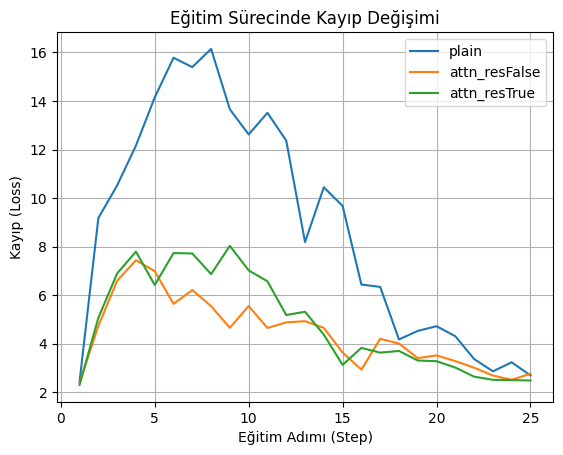

In [28]:
import matplotlib.pyplot as plt

plt.figure()
for name in logs.keys():
    plt.plot(range(1, len(logs[name]["loss"]) + 1),
             logs[name]["loss"],
             label=name)

plt.xlabel("Eğitim Adımı (Step)")
plt.ylabel("Kayıp (Loss)")
plt.title("Eğitim Sürecinde Kayıp Değişimi")
plt.legend()
plt.grid(True)
plt.show()



## 🔹 Gradient Grafiği

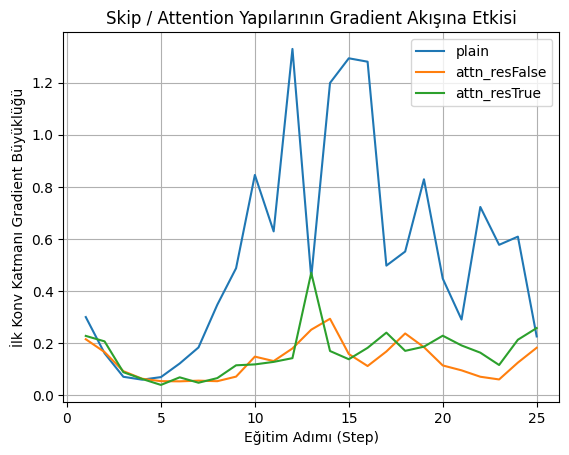

In [29]:
plt.figure()
for name in logs.keys():
    plt.plot(range(1, len(logs[name]["g"]) + 1),
             logs[name]["g"],
             label=name)

plt.xlabel("Eğitim Adımı (Step)")
plt.ylabel("İlk Konv Katmanı Gradient Büyüklüğü")
plt.title("Skip / Attention Yapılarının Gradient Akışına Etkisi")
plt.legend()
plt.grid(True)
plt.show()


## 🔹 Log-scale

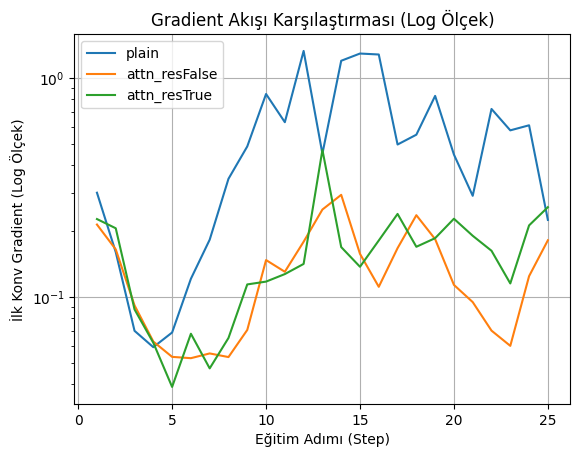

In [30]:
plt.figure()
for name in logs.keys():
    plt.plot(range(1, len(logs[name]["g"]) + 1),
             logs[name]["g"],
             label=name)

plt.yscale("log")
plt.xlabel("Eğitim Adımı (Step)")
plt.ylabel("İlk Konv Gradient (Log Ölçek)")
plt.title("Gradient Akışı Karşılaştırması (Log Ölçek)")
plt.legend()
plt.grid(True)
plt.show()


## Residual ve Attention Yapılarının Karşılaştırmalı Analizi

Bu çalışmada, residual ağlar ile attention mekanizmalarının birlikte kullanımının
eğitim dinamikleri üzerindeki etkisi incelenmiştir. Üç farklı mimari yapı
karşılaştırılmıştır:

- **plain**: Attention içermeyen, yalnızca temel ResNet yapısı  
- **attn_resFalse**: Attention modülü içeren, ancak attention içinde residual karışım bulunmayan yapı  
- **attn_resTrue**: Attention modülü içeren ve attention içinde residual karışım aktif olan yapı  

Amaç, bu yapıların **kayıp fonksiyonu davranışı** ve **gradyan akışı**
açısından karşılaştırmalı olarak değerlendirilmesidir.



## Kayıp (Loss) Davranışı

Eğitim süreci boyunca elde edilen sonuçlar incelendiğinde, attention içermeyen
plain modelin özellikle eğitim başlangıcında yüksek ve düzensiz kayıp değerleri
ürettiği gözlemlenmiştir. Bu durum, ağın erken safhada kararsız bir optimizasyon
süreci yaşadığını göstermektedir.

Attention kullanılan modellerde ise kayıp artışı daha sınırlı ve kontrollüdür.
Attention içinde residual karışımın aktif olduğu yapı (**attn_resTrue**),
eğitim boyunca daha yumuşak bir kayıp eğrisi üretmiş ve en düşük son kayıp
değerine ulaşmıştır.



## Gradyan Akışı Analizi

İlk konvolüsyon katmanına ulaşan gradyan büyüklükleri incelendiğinde,
plain modelde gradyanların zaman zaman aşırı büyüdüğü ve ciddi dalgalanmalar
gösterdiği tespit edilmiştir. Bu durum, gradyan patlaması riskine işaret etmektedir.

Attention içeren modellerde gradyan akışı belirgin biçimde dengelenmiştir.
Özellikle attention içinde residual karışımın aktif olduğu yapı,
gradyanların ne aşırı bastırılmasına ne de kontrolsüz büyümesine izin vermiştir.
Log-ölçekli gradyan analizleri, **attn_resTrue** yapısının en sağlıklı
gradyan dağılımını sağladığını göstermektedir.


## Parametre Sayıları ve Eğitim Kararlılığı

Attention modülünün eklenmesi parametre sayısını artırmış olsa da,
eğitim sürecinde sağlanan stabilite ve dengeli gradyan akışı bu ek maliyeti
anlamlı kılmaktadır. Attention içinde residual karışımın varlığı,
parametre sayısını değiştirmemekle birlikte öğrenme davranışını
olumlu yönde etkilemiştir.



## Karşılaştırmalı Özet

| Model          | Attention | Attention İçinde Residual | Eğitim Başlangıcı | Gradyan Akışı      | Son Kayıp | Genel Stabilite |
|---------------|-----------|---------------------------|-------------------|--------------------|-----------|----------------|
| plain         | Yok       | Yok                       | Kararsız          | Dalgalı / Patlamaya açık | Orta      | Düşük          |
| attn_resFalse | Var       | Yok                       | Kontrollü         | Stabil fakat zayıf | Orta      | Orta           |
| attn_resTrue  | Var       | Var                       | En stabil         | Dengeli ve sağlıklı | En düşük  | Yüksek         |


## Genel Değerlendirme

Elde edilen bulgular, attention mekanizmasının residual ağlarda eğitimi
belirgin biçimde stabilize ettiğini göstermektedir. Attention içinde residual
karışımın kontrollü bir biçimde uygulanması, gradyan akışını daha sağlıklı hale
getirmiş ve genel öğrenme davranışını iyileştirmiştir.
